## FOCuS fast algorithm for Poisson data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
   
class Quadratic:
    def __init__(self, a, b):
        self.a = a
        self.b = b
    
    def __repr__(self):
        return f'Quadratic: {self.a}x^2+{self.b}x'
    
    def __sub__(self, other_quadratic):
        #subtraction: needed for quadratic differences
        return Quadratic(self.a-other_quadratic.a, self.b-other_quadratic.b)
    
    def __add__(self, other_quadratic):
        #addition: needed for quadratic differences
        return Quadratic(self.a+other_quadratic.a, self.b+other_quadratic.b)
    
    def evaluate(self, mu):
        return np.maximum(self.a*mu**2 + self.b*mu, 0)
    
    def update(self, X_T):
        return Quadratic(self.a - 1, self.b + 2*X_T)
    
    def ymax(self):
        return -self.b**2/(4*self.a) 
    
    def xmax(self):
        if (self.a==0)and(self.b==0):
            return 0
        else:
            return -self.b/(2*self.a)
    
    def dominates(self, other_quadratic):
        return (self.b>other_quadratic.b)and(self.xmax()>other_quadratic.xmax())
    
    def __add__(self, other_quadratic):
        #addition
        return Quadratic(self.a+other_quadratic.a, self.b+other_quadratic.b)
    
    def __sub__(self, other_quadratic):
        #subtraction
        return Quadratic(self.a-other_quadratic.a, self.b-other_quadratic.b)

Our algorithm operates on this list of quadratics. At each timestep, it starts from the left (earliest $\tau$ still under consideration) and updates the quadratics sequentially, checking as it goes whether any need pruning and calculating the global maximum. When it reaches the end of the list, it adds a new quadratic for a change beginning at $T$ if the point $X_T$ is big enough to need one.

In [187]:
def focus_step_fast_gaussian(quadratic_difference_list, final_quadratic, max_list, X_t, threshold=25, min_parameter=1):
    #min_parameter = (1- μ_min)/log(μ_min), avoids having to calculate logarithms
    
    #starting values:
    #quadratic_difference_list = []
    #final_quadratic = Quadratic(0, 0)
    #max_list = [0]

    pruning_required = True
    maxima_required = True
    threshold_met = False

    #start by performing an update:
    if -2*X_t*final_quadratic.b > final_quadratic.a:
        #add another quadratic on
        new_final_quadratic = Curve(-1, 2*X_t)
        quadratic_difference_list.append(final_quadratic)
        max_list.append(max_list[-1] + final_quadratic.ymax()) #requires evaluating a logarithm
        pruning_required=False
    else:
        #just update the final quadratic
        new_final_quadratic = final_quadratic.update(X_t, λ)


    while pruning_required:

        if quadratic_difference_list: #nonempty
            second_to_last_quadratic = new_final_quadratic+quadratic_difference_list[-1]
            if second_to_last_quadratic.dominates(new_final_quadratic):
                #prune out
                quadratic_difference_list.pop()
                max_list.pop()
                new_final_quadratic = second_to_last_quadratic
            else:
                #no more pruning checks required
                pruning_required=False
        
        else: #empty quadratic differences: final quadratic is only quadratic.
            #evaluate whether only nonzero on  1 < μ <  μ_min (min_parameter=1 corresponds to μ_min=1)
            if new_final_quadratic.a < min_parameter * -new_final_quadratic.b:
                new_final_quadratic = Curve(0, 0, t=0)
                
            else:#check the maximum here
                if new_final_quadratic.ymax() > threshold: #requires evaluating a logarithm
                    threshold_met=True
                    
            pruning_required=False
            maxima_required=False
                
    #check maximum
    i = 1
    quadratic_being_checked = new_final_quadratic
    while maxima_required:
        
        quadratic_max = quadratic_being_checked.ymax() #requires evaluating a logarithm

        if quadratic_max+max_list[-i] < threshold:
            #no quadratic maxima meets the threshold
            maxima_required = False

        elif quadratic_max >= threshold:
            threshold_met=True
            maxima_required=False

        else: #iterate leftwards through quadratic list
            quadratic_being_checked = quadratic_being_checked + quadratic_difference_list[-i]
            i += 1

    return quadratic_difference_list, new_final_quadratic, max_list, threshold_met    
        
from copy import copy
def interpret(quadratic_difference_list, final_quadratic):
    #Takes the internals of the fast FOCuS algorithm and re-interprets them in the same format as the internals of the basic FOCuS algorithm
    global_max=final_quadratic.ymax()
    time_offset=final_quadratic.t
    quadratic_list=[final_quadratic]
    quadratic_being_checked = final_quadratic
        
    for i in range(1, len(quadratic_difference_list)+1):
        quadratic_being_checked = quadratic_being_checked + quadratic_difference_list[-i]
        
        quadratic_list.append(copy(quadratic_being_checked))
        
        if quadratic_being_checked.ymax() > global_max:
            global_max = quadratic_being_checked.ymax()
            time_offset = quadratic_being_checked.t
    quadratic_list.reverse()
    
    return quadratic_list, global_max, time_offset

def plot_quadratics(quadratic_list, threshold=25, t=0):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title("FOCuS Step")
    
    ax.set_xlabel("$\mu$")
    ax.set_ylabel("$S_{t}(\mu)$", rotation=0)
    
    ax.set_ylim(-1, threshold+1)
    ax.set_xlim(-0.2, 5.2)
    
    
    ax.axhline(threshold, color='C1')

    mu = np.linspace(0.2, 10, 100) #the x-axis for the plot
    
    for c in quadratic_list:
        ax.plot(mu, c.evaluate(mu), label=f'$\\tau={c.t+t+1}$')
    
    ax.axhline(0, color='C0')

    if quadratic_list:
        ax.legend(loc='upper left')
    return fig

In [188]:
def focus_fast_poisson(X, λ, μ_min=1, threshold=12.5, plot=False):
    
    if μ_min==1:
        min_parameter=1
    else:
        min_parameter = (μ_min-1)/np.log(μ_min)
    quadratic_difference_list=[]
    max_list=[0]
    final_quadratic=Curve(0, 0, t=0)
    
    if np.ndim(λ)==0:#scalar
        λ = np.full(X.shape, λ)
    
    for t in range(len(X)):
        quadratic_difference_list, final_quadratic, max_list, threshold_met  = focus_step_fast(quadratic_difference_list,
                                                                                       final_quadratic,
                                                                                       max_list,
                                                                                       X[t], λ[t],
                                                                                       threshold,
                                                                                       min_parameter)
        
        #print(quadratic_difference_list)
        
        if plot:
            clear_output(wait=True)
            quadratic_list, global_max, time_offset = interpret(quadratic_difference_list, final_quadratic)
            upper_bound = max_list[-1] + final_quadratic.ymax()
            plot_quadratics(quadratic_list, threshold=threshold, t=t)
            plt.hlines(upper_bound, xmin=1, xmax=4, color="black")
            plt.show()
            #print(quadratic_list)
        
        #print(max_list)
        if threshold_met:
            quadratic_list, global_max, time_offset = interpret(quadratic_difference_list, final_quadratic)
            significance, changepoint, stopping_time = global_max, t+time_offset+1, t
            return significance, changepoint, stopping_time
    
    return 0, None, len(X)+1

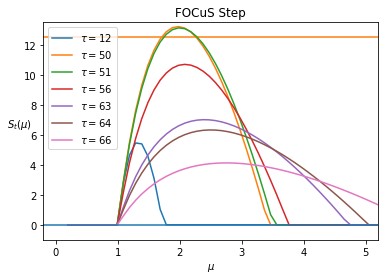

In [189]:
import warnings
warnings.filterwarnings("ignore")

from scipy import stats
np.random.seed(42)
threshold=12.5
X = np.concatenate((stats.poisson(mu=2).rvs(size=50), stats.poisson(mu=4).rvs(size=50)))

significance, changepoint, stopping_time = focus_fast(X, λ=2, μ_min=1, threshold=12.5, plot=True)

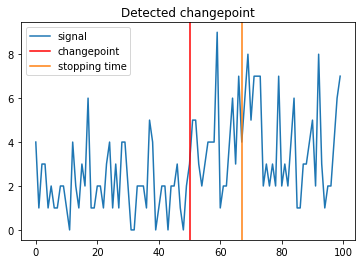

In [154]:
plt.plot(X)
plt.title("Detected changepoint")
if changepoint is not None:
    plt.axvline(changepoint, color='red')
    plt.axvline(stopping_time, color='C1')
    plt.legend(['signal','changepoint', 'stopping time'])